<a href="https://colab.research.google.com/github/ZoraizQ/brain_mas_classifier/blob/master/brain_mas_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifier for Human Brain Mental Attention State using EEG BCI-based data

In [103]:
import os
import random
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from scipy.io import loadmat
import pandas as pd

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.wrappers import TimeDistributed
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import AveragePooling2D
from keras.layers.recurrent import LSTM
from keras.optimizers import Adam
from keras import regularizers
from keras.callbacks import ModelCheckpoint

from sklearn.utils import shuffle



SAMP_FREQ = 128 # SAMPLING FREQUENCY Hz (samples/second)
CLASSES = {
    0: 'focused',
    1: 'unfocused',
    2: 'drowsy'
}

ONEHOT = {
    0: np.array([1,0,0]),
    1: np.array([0,1,0]),
    2: np.array([0,0,1])
}

In [104]:
! pip install --upgrade --force-reinstall --no-deps kaggle

from google.colab import files
files.upload() #upload kaggle.json

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Processing /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303/kaggle-1.5.12-cp37-none-any.whl
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [105]:
! [ ! -d /content/data ] && kaggle datasets download -d 'inancigdem/eeg-data-for-mental-attention-state-detection' -p '/content/data' --unzip

# Data Preprocessing

In [106]:
DATA_FOLDER = '/content/data'

filenames = np.array(glob(os.path.join(DATA_FOLDER, '*/*.mat')))

NUM_FILES_ALL = len(filenames) # with habituation and trial experiments both
print("Total number of records: " + str(NUM_FILES_ALL))

'''
Each participant took part in 7 experiments, performing at most one experiment per day. 
The first 2 experiments were used for habituation, and the last 5 trials were used for collecting the data. 
The first 7 experiments belong to Subject 1, the next 7 experiments belong to Subject 2, and go on. 
However, Subject 5 could not complete the last experiment. 
Therefore, there are 34 records in the dataset.
'''


img_folder_path = '/'.join(filenames[0].split('/')[:-1])
filenames_trials = []  # remove records of habituation first, second of each subject's set out of 7
for i in range(3, NUM_FILES_ALL, 7):
    for j in range(i, min(i+5, NUM_FILES_ALL+1)):
        filenames_trials.append(img_folder_path+'/'+'eeg_record'+str(j)+'.mat')

print(filenames_trials)
NUM_FILES = len(filenames_trials)
print("Number of trial experiment records: " + str(NUM_FILES))

Total number of records: 34
['/content/data/EEG Data/eeg_record3.mat', '/content/data/EEG Data/eeg_record4.mat', '/content/data/EEG Data/eeg_record5.mat', '/content/data/EEG Data/eeg_record6.mat', '/content/data/EEG Data/eeg_record7.mat', '/content/data/EEG Data/eeg_record10.mat', '/content/data/EEG Data/eeg_record11.mat', '/content/data/EEG Data/eeg_record12.mat', '/content/data/EEG Data/eeg_record13.mat', '/content/data/EEG Data/eeg_record14.mat', '/content/data/EEG Data/eeg_record17.mat', '/content/data/EEG Data/eeg_record18.mat', '/content/data/EEG Data/eeg_record19.mat', '/content/data/EEG Data/eeg_record20.mat', '/content/data/EEG Data/eeg_record21.mat', '/content/data/EEG Data/eeg_record24.mat', '/content/data/EEG Data/eeg_record25.mat', '/content/data/EEG Data/eeg_record26.mat', '/content/data/EEG Data/eeg_record27.mat', '/content/data/EEG Data/eeg_record28.mat', '/content/data/EEG Data/eeg_record31.mat', '/content/data/EEG Data/eeg_record32.mat', '/content/data/EEG Data/eeg_re

data: (357224, 25)


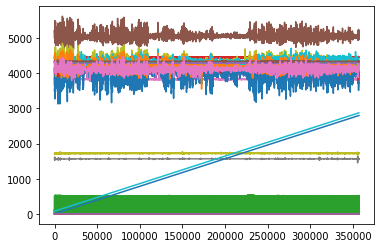


data_eeg: (357224, 14)


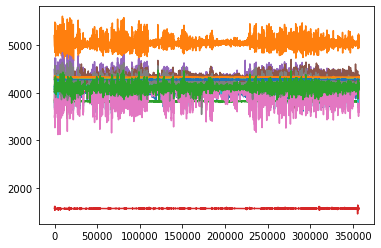


trials: (1, 2, 14, 128)

data: (380344, 25)


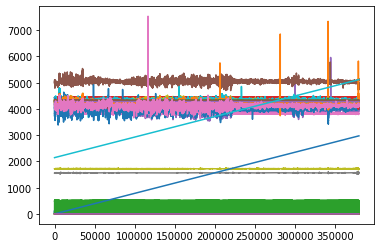


data_eeg: (380344, 14)


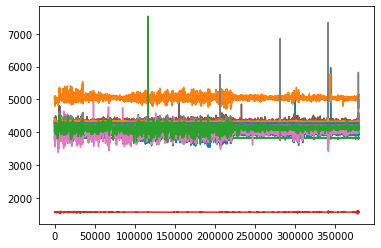


trials: (1, 2, 14, 128)

data: (351204, 25)


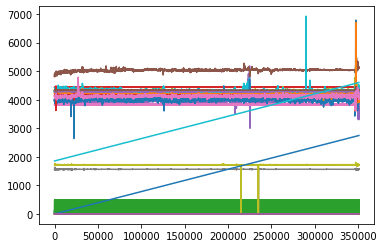


data_eeg: (351204, 14)


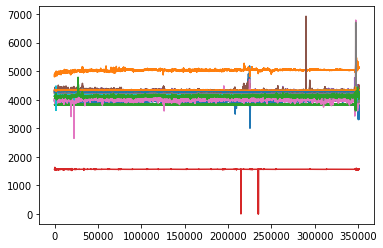


trials: (1, 2, 14, 128)

data: (288752, 25)


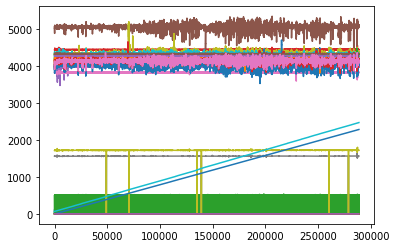


data_eeg: (288752, 14)


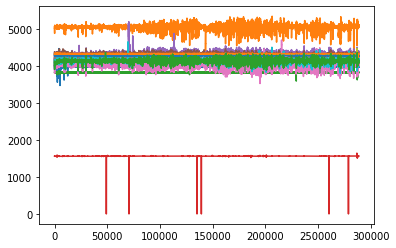


trials: (1, 2, 14, 128)

data: (398816, 25)


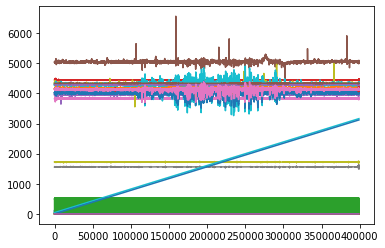


data_eeg: (398816, 14)


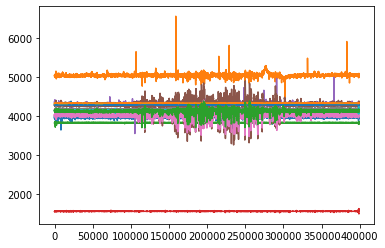


trials: (1, 3, 14, 128)

data: (381340, 25)


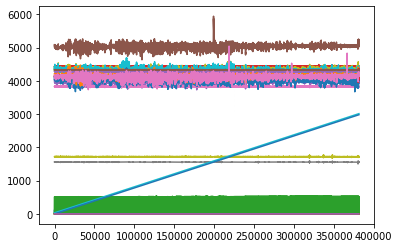


data_eeg: (381340, 14)


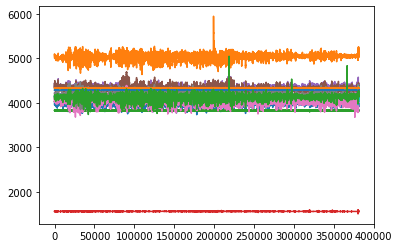


trials: (1, 2, 14, 128)

data: (391624, 25)


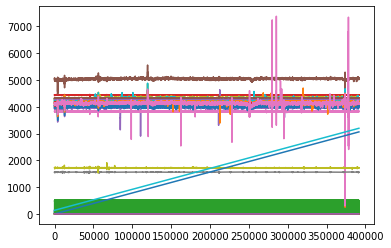


data_eeg: (391624, 14)


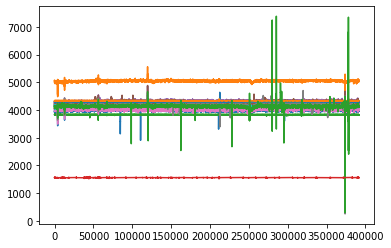


trials: (1, 3, 14, 128)

data: (356728, 25)


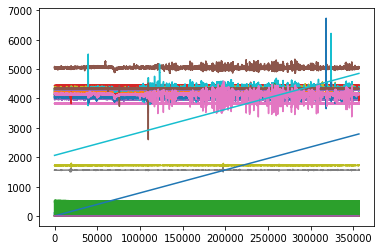


data_eeg: (356728, 14)


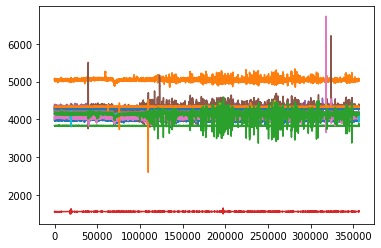


trials: (1, 2, 14, 128)

data: (373304, 25)


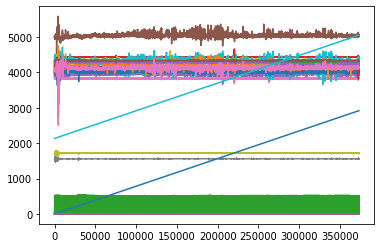


data_eeg: (373304, 14)


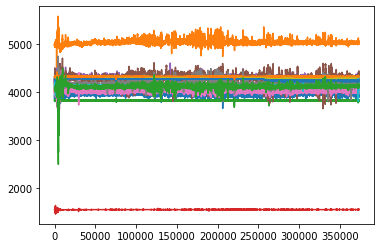


trials: (1, 2, 14, 128)

data: (345164, 25)


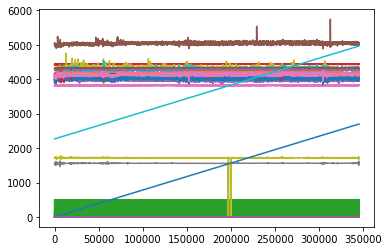


data_eeg: (345164, 14)


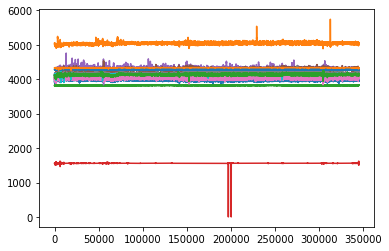


trials: (1, 2, 14, 128)



In [107]:
'''
Each Matlab file contains the object of the data acquired from EMOTIV device during one experiment. 
The raw data is contained in o.data, which is array of size {number-of-samples}x25, thus o.data(:,i) comprises one data channel. 
The sampling frequency is 128 Hz. The list of data channels and their numerical ids is given below per EMOTIV documentation;

25 CHANNELS:

1-'EDCOUNTER' 2-'EDINTERPOLATED'
3-'EDRAWCQ'
------------
4-'EDAF3' 5-'EDF7'
6-'EDF3' 7-'EDFC5'
8-'EDT7' 9-'EDP7'
10-'EDO1' 11-'EDO2'
12-'EDP8' 13-'EDT8'
14-'EDFC6' 15-'EDF4'
16-'EDF8' 17-'EDAF4'
--------------
18-'EDGYROX' 19-'EDGYROY'
20-'EDTIMESTAMP' 21-'EDESTIMESTAMP' 22-'EDFUNCID' 23-'EDFUNCVALUE' 24-'EDMARKER'
25'EDSYNCSIGNAL'

The EEG data is in the channels 4:17.

'''

for i in range(10):
    record = loadmat(filenames_trials[i])
    mdata = record['o']  # main object 
    sample1 = {n: mdata[n][0,0] for n in mdata.dtype.names}

    data = sample1['data']
    trials = sample1['trials']

    print('data:', data.shape)
    plt.plot(data)
    plt.show()

    data_eeg = data[:,4:18]
    print('\ndata_eeg:', data_eeg.shape)
    plt.plot(data_eeg)
    plt.show()

    print('\ntrials:', trials.shape)
    print()

In [108]:
x = []
y = []

'''
Every experiments have same labels:
Focuse: 0 to 10 min
Unfocused: 10 to 20min
Sleep: 20 to end of experiments
'''

TRIAL_SECONDS = 12
MARK_10MIN, MARK_20MIN = 10*60*SAMP_FREQ, 20*60*SAMP_FREQ 
TRIAL_LENGTH = TRIAL_SECONDS*SAMP_FREQ
NUM_TRIALS = MARK_10MIN//TRIAL_LENGTH
NUM_CHAN = 14

print(MARK_10MIN, TRIAL_LENGTH, NUM_TRIALS)

def mean_normalize(x):
    mu = np.mean(x, axis=1)
    mu = mu.reshape(mu.shape+(1,))
    sigma = np.std(x, axis=1)
    sigma = sigma.reshape(sigma.shape+(1,))
    x = (x - mu) / sigma
    return x

for fn in filenames_trials:
    record = loadmat(fn)
    mdata = record['o']  # main object 
    ndata = {n: mdata[n][0,0] for n in mdata.dtype.names}

    data = ndata['data'][:,4:18] # 4-17 EEG data channels only
    ns = data.shape[0]

    focused_10min = np.array(data[:MARK_10MIN])
    focused_10min = mean_normalize(focused_10min)

    focused_trials = np.split(focused_10min, NUM_TRIALS)

    x += focused_trials # from the start
    y += [ONEHOT[0]]*NUM_TRIALS # focused


    unfocused_10min = data[MARK_10MIN:MARK_20MIN]
    unfocused_10min = mean_normalize(unfocused_10min)

    unfocused_trials = np.split(unfocused_10min, NUM_TRIALS)
    x += unfocused_trials
    y += [ONEHOT[1]]*NUM_TRIALS # unfocused

    '''
    there is more drowsy data until the file's end,
    (60940, 14) sample drowsy
    '''
    drowsy_10min = data[MARK_20MIN:MARK_20MIN+MARK_10MIN]
    drowsy_10min = mean_normalize(drowsy_10min)

    if (drowsy_10min.shape[0] == MARK_10MIN):
        drowsy_trials = np.split(drowsy_10min, NUM_TRIALS)
        x += drowsy_trials# until the end, 
        y += [ONEHOT[2]]*NUM_TRIALS # drowsy
    else:
        print(drowsy_10min.shape)


print(len(x), len(y))

76800 1536 50
(60940, 14)
3550 3550


focused (1536, 14)


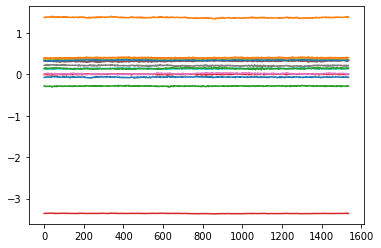


unfocused (1536, 14)


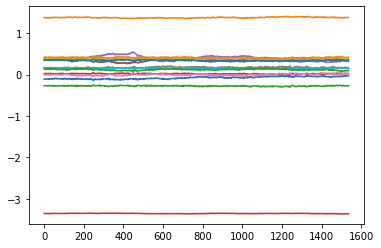


focused (1536, 14)


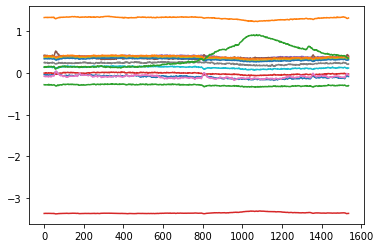


unfocused (1536, 14)


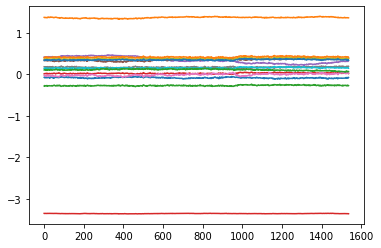


focused (1536, 14)


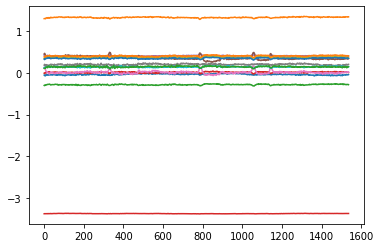


drowsy (1536, 14)


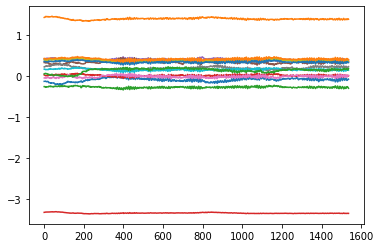


unfocused (1536, 14)


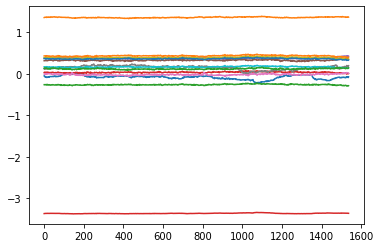


drowsy (1536, 14)


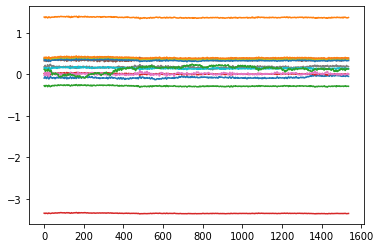


unfocused (1536, 14)


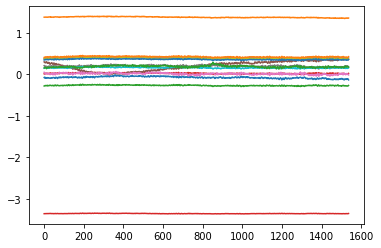


focused (1536, 14)


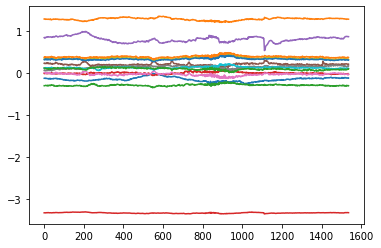


(2840, 1536, 14, 1) (2840, 3)


In [109]:
TOTAL_SAMPLES = len(x)
NUM_TRAIN = int(0.8 * TOTAL_SAMPLES)

# unshuffled so class balanced
x_train = x[:NUM_TRAIN]
y_train = y[:NUM_TRAIN]

x_test = x[NUM_TRAIN:]
y_test = y[NUM_TRAIN:]

x_train, y_train = shuffle(x_train, y_train, random_state=0)
x_test, y_test = shuffle(x_test, y_test, random_state=0)

for i in range(10):
    print(CLASSES[np.argmax(y_train[i])], x_train[i].shape)
    plt.plot(x_train[i])
    plt.show()
    print()

x_train = np.array(x_train)
x_train = np.reshape(x_train, (*x_train.shape, 1))
y_train = np.array(y_train)
# y_train = np.reshape(y_train, (*y_train.shape))


print(x_train.shape, y_train.shape)


In [110]:
'''
https://github.com/Kearlay/research/blob/master/py/eeg_main.py
https://github.com/hauke-d/cnn-eeg/blob/master/models.py
https://backend.orbit.dtu.dk/ws/files/152316980/1_s2.0_S0957417418305359_main.pdf
'''

'\nhttps://github.com/Kearlay/research/blob/master/py/eeg_main.py\nhttps://github.com/hauke-d/cnn-eeg/blob/master/models.py\nhttps://backend.orbit.dtu.dk/ws/files/152316980/1_s2.0_S0957417418305359_main.pdf\n'

In [111]:
def create_CNN1(nchan, nclasses, trial_length=1024, l1=0, lr=1e-4):
    POOLING_STRIDES = 30

    input_shape = (trial_length, nchan, 1)
    model = Sequential()

    model.add(Conv2D(64, (60, 1), activation="relu", kernel_regularizer=regularizers.l1(l1), padding="same", input_shape=input_shape)) # temporal convolution (30,1) 40 filters
    model.add(Conv2D(64, (1, nchan), activation="relu", kernel_regularizer=regularizers.l1(l1), padding="valid")) # spatial convolution, inside bounds so no padding (1, 14) 40 filters

    model.add(AveragePooling2D((60, 1), strides=(POOLING_STRIDES, 1)))

    model.add(Flatten())

    model.add(Dense(1500, activation="relu"))
    model.add(Dense(300, activation="relu"))
    model.add(Dense(80, activation="relu"))

    model.add(Dense(nclasses, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer=Adam(lr), metrics=["accuracy"])

    return model


def create_CNN2(nchan, nclasses, trial_length=1024, l1=0, lr=1e-4):
    POOLING_STRIDES = 15

    input_shape = (trial_length, nchan, 1)
    model = Sequential()

    model.add(Conv2D(40, (30, 1), activation="relu", kernel_regularizer=regularizers.l1(l1), padding="same", input_shape=input_shape)) # temporal convolution (30,1) 40 filters
    model.add(Conv2D(40, (1, nchan), activation="relu", kernel_regularizer=regularizers.l1(l1), padding="valid")) # spatial convolution, inside bounds so no padding (1, 14) 40 filters
    model.add(AveragePooling2D((30, 1), strides=(POOLING_STRIDES, 1)))

    model.add(Flatten())

    model.add(Dense(1500, activation="relu"))
    model.add(Dense(300, activation="relu"))
    model.add(Dense(80, activation="relu"))

    model.add(Dense(nclasses, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer=Adam(lr), metrics=["accuracy"])

    return model


def create_CNN3(nchan, nclasses, trial_length=1024, l1=0, lr=1e-4):
    POOLING_STRIDES = 15

    input_shape = (trial_length, nchan, 1)
    model = Sequential()

    model.add(Conv2D(64, (30, 1), activation="relu", kernel_regularizer=regularizers.l1(l1), padding="same", input_shape=input_shape)) # temporal convolution (30,1) 40 filters
    model.add(Conv2D(64, (1, nchan), activation="relu", kernel_regularizer=regularizers.l1(l1), padding="valid")) # spatial convolution, inside bounds so no padding (1, 14) 40 filters
    model.add(AveragePooling2D((30, 1), strides=(POOLING_STRIDES, 1)))

    model.add(Flatten())

    model.add(Dense(300, activation="relu"))
    model.add(Dense(80, activation="relu"))

    model.add(Dense(nclasses, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer=Adam(lr), metrics=["accuracy"])

    return model


def create_CNN4(nchan, nclasses, trial_length=1024, l1=0, lr=1e-4):
    POOLING_STRIDES = 15

    input_shape = (trial_length, nchan, 1)
    model = Sequential()

    model.add(Conv2D(40, (30, 1), activation="relu", kernel_regularizer=regularizers.l1(l1), padding="same", input_shape=input_shape)) # temporal convolution (30,1) 40 filters
    model.add(Conv2D(40, (1, nchan), activation="relu", kernel_regularizer=regularizers.l1(l1), padding="valid")) # spatial convolution, inside bounds so no padding (1, 14) 40 filters
    model.add(AveragePooling2D((30, 1), strides=(POOLING_STRIDES, 1)))
    model.add(Flatten())

    model.add(Dense(80, activation="relu"))

    model.add(Dense(nclasses, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer=Adam(lr), metrics=["accuracy"])

    return model

def create_CRNN1(nchan, nclasses, trial_length=1024, l1=0, full_output=False):
    input_shape = (trial_length, nchan, 1)
    model = Sequential()
    model.add(Conv2D(40, (30, 1), activation="relu", kernel_regularizer=regularizers.l1(l1), padding="same", input_shape=input_shape))
    model.add(Conv2D(40, (1, nchan), activation="relu", kernel_regularizer=regularizers.l1(l1), padding="valid"))
    model.add(AveragePooling2D((5, 1), strides=(5, 1)))
    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(40, activation="sigmoid", dropout=0.25, return_sequences=full_output))

    model.add(Dense(15, activation="relu"))

    model.add(Dense(nclasses, activation="softmax"))

    model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
    return model

def create_CRNN2(nchan, nclasses, trial_length=1024, l1=0, full_output=False):
    input_shape = (trial_length, nchan, 1)
    model = Sequential()
    model.add(Conv2D(40, (30, 1), activation="relu", kernel_regularizer=regularizers.l1(l1), padding="same", input_shape=input_shape))
    model.add(Conv2D(40, (1, nchan), activation="relu", kernel_regularizer=regularizers.l1(l1), padding="valid"))
    model.add(AveragePooling2D((5, 1), strides=(5, 1)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(40, activation="sigmoid", dropout=0.25, return_sequences=full_output))
    model.add(Dense(nclasses, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
    return model

def create_CRNN3(nchan, nclasses, trial_length=1024, l1=0, full_output=False):
    input_shape = (trial_length, nchan, 1)
    model = Sequential()
    model.add(Conv2D(64, (30, 1), activation="relu", kernel_regularizer=regularizers.l1(l1), padding="same", input_shape=input_shape))
    model.add(Conv2D(64, (1, nchan), activation="relu", kernel_regularizer=regularizers.l1(l1), padding="valid"))
    model.add(AveragePooling2D((5, 1), strides=(5, 1)))
    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(40, activation="sigmoid", dropout=0.25, return_sequences=full_output))

    model.add(Dense(15, activation="relu"))

    model.add(Dense(nclasses, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
    return model


def create_CRNN4(nchan, nclasses, trial_length=1024, l1=0, full_output=False):
    input_shape = (trial_length, nchan, 1)
    model = Sequential()
    model.add(Conv2D(40, (30, 1), activation="relu", kernel_regularizer=regularizers.l1(l1), padding="same", input_shape=input_shape))
    model.add(Conv2D(40, (1, nchan), activation="relu", kernel_regularizer=regularizers.l1(l1), padding="valid"))
    model.add(AveragePooling2D((5, 1), strides=(5, 1)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(40, activation="sigmoid", dropout=0.25, return_sequences=full_output))
    model.add(Dense(nclasses, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
    return model


def create_CRNN5(nchan, nclasses, trial_length=1024, l1=0, full_output=False):
    input_shape = (trial_length, nchan, 1)
    model = Sequential()
    model.add(Conv2D(64, (30, 1), activation="relu", kernel_regularizer=regularizers.l1(l1), padding="same", input_shape=input_shape))
    model.add(Conv2D(64, (1, nchan), activation="relu", kernel_regularizer=regularizers.l1(l1), padding="valid"))
    model.add(AveragePooling2D((5, 1), strides=(5, 1)))
    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(40, activation="sigmoid", dropout=0.25, return_sequences=full_output))

    model.add(Dense(25, activation="relu"))
    
    model.add(Dense(15, activation="relu"))
    
    model.add(Dense(nclasses, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
    return model

In [112]:
# model1 = create_CNN1(nchan=NUM_CHAN, nclasses=len(CLASSES), trial_length=TRIAL_LENGTH, lr=LR)
# model1.summary()


model2 = create_CNN2(nchan=NUM_CHAN, nclasses=len(CLASSES), trial_length=TRIAL_LENGTH, lr=LR)
model2.summary()


# model3 = create_CNN3(nchan=NUM_CHAN, nclasses=len(CLASSES), trial_length=TRIAL_LENGTH, lr=LR)
# model3.summary()


model4 = create_CNN4(nchan=NUM_CHAN, nclasses=len(CLASSES), trial_length=TRIAL_LENGTH)
model4.summary()


model5 = create_CRNN1(nchan=NUM_CHAN, nclasses=len(CLASSES), trial_length=TRIAL_LENGTH)
model5.summary()


# model6 = create_CRNN2(nchan=NUM_CHAN, nclasses=len(CLASSES), trial_length=TRIAL_LENGTH)
# model6.summary()


# model7 = create_CRNN3(nchan=NUM_CHAN, nclasses=len(CLASSES), trial_length=TRIAL_LENGTH)
# model7.summary()


model8 = create_CRNN4(nchan=NUM_CHAN, nclasses=len(CLASSES), trial_length=TRIAL_LENGTH)
model8.summary()


# model9 = create_CRNN5(nchan=NUM_CHAN, nclasses=len(CLASSES), trial_length=TRIAL_LENGTH)
# model9.summary()

Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_112 (Conv2D)          (None, 1536, 14, 40)      1240      
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 1536, 1, 40)       22440     
_________________________________________________________________
average_pooling2d_56 (Averag (None, 101, 1, 40)        0         
_________________________________________________________________
flatten_56 (Flatten)         (None, 4040)              0         
_________________________________________________________________
dense_127 (Dense)            (None, 1500)              6061500   
_________________________________________________________________
dense_128 (Dense)            (None, 300)               450300    
_________________________________________________________________
dense_129 (Dense)            (None, 80)              

In [113]:
def plot_accuracy_loss(history):
    plt.plot(history.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.show()

    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

In [114]:
LR = 1e-6
N_EPOCHS = 1000
BATCH_SIZE = 16
#  NUM_BATCHES 

Epoch 1/1000
178/178 [==============================] - 9s 46ms/step - loss: 1.0994 - accuracy: 0.3347
Epoch 2/1000
178/178 [==============================] - 8s 46ms/step - loss: 1.0982 - accuracy: 0.3367
Epoch 3/1000
178/178 [==============================] - 8s 45ms/step - loss: 1.0978 - accuracy: 0.3533
Epoch 4/1000
178/178 [==============================] - 8s 46ms/step - loss: 1.0979 - accuracy: 0.3378
Epoch 5/1000
178/178 [==============================] - 8s 46ms/step - loss: 1.0975 - accuracy: 0.3448
Epoch 6/1000
178/178 [==============================] - 8s 46ms/step - loss: 1.0970 - accuracy: 0.3554
Epoch 7/1000
178/178 [==============================] - 8s 47ms/step - loss: 1.0970 - accuracy: 0.3540
Epoch 8/1000
178/178 [==============================] - 8s 47ms/step - loss: 1.0968 - accuracy: 0.3776
Epoch 9/1000
178/178 [==============================] - 8s 46ms/step - loss: 1.0965 - accuracy: 0.3723
Epoch 10/1000
178/178 [==============================] - 8s 46ms/step - l

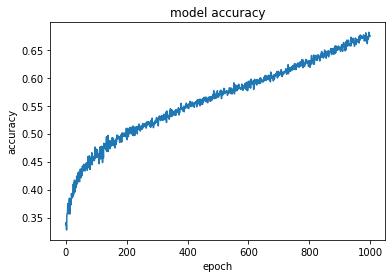

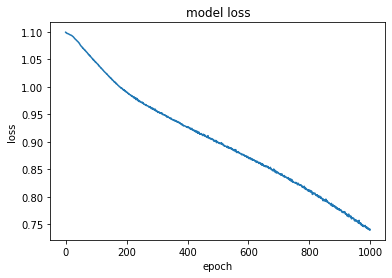

In [115]:
history = model2.fit( x_train, y_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS)
plot_accuracy_loss(history)

In [ ]:
history = model4.fit( x_train, y_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS)
plot_accuracy_loss(history)

Epoch 1/1000
178/178 [==============================] - 8s 41ms/step - loss: 1.1053 - accuracy: 0.3170
Epoch 2/1000
178/178 [==============================] - 7s 41ms/step - loss: 1.0993 - accuracy: 0.3302
Epoch 3/1000
178/178 [==============================] - 7s 41ms/step - loss: 1.0970 - accuracy: 0.3500
Epoch 4/1000
178/178 [==============================] - 7s 41ms/step - loss: 1.0958 - accuracy: 0.3407
Epoch 5/1000
178/178 [==============================] - 7s 41ms/step - loss: 1.0934 - accuracy: 0.3452
Epoch 6/1000
178/178 [==============================] - 7s 41ms/step - loss: 1.0865 - accuracy: 0.3668
Epoch 7/1000
178/178 [==============================] - 7s 42ms/step - loss: 1.0780 - accuracy: 0.3785
Epoch 8/1000
178/178 [==============================] - 7s 42ms/step - loss: 1.0663 - accuracy: 0.3958
Epoch 9/1000
178/178 [==============================] - 7s 41ms/step - loss: 1.0594 - accuracy: 0.3793
Epoch 10/1000
178/178 [==============================] - 7s 41ms/step - l

In [ ]:
history = model5.fit( x_train, y_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS)
plot_accuracy_loss(history)

In [ ]:
history = model8.fit( x_train, y_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS)
plot_accuracy_loss(history)

In [ ]:
model2.save('model2')
model4.save('model4')
model5.save('model5')
model8.save('model8')